**Cassava disease classification problem**

There are two places we can get the cassava dataset: [one at Kaggle](https://www.kaggle.com/c/cassava-disease) and [one at Tensorflow](https://www.tensorflow.org/datasets/catalog/cassava). Let's start with the Kaggle version.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cassava-disease/random.txt
/kaggle/input/cassava-disease/train.zip
/kaggle/input/cassava-disease/sample_submission_file.csv
/kaggle/input/cassava-disease/extraimages.zip
/kaggle/input/cassava-disease/test.zip


In [3]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.python.framework import ops
import math
import glob
import zipfile
import tensorflow_datasets as tfds
# from skimage.transform import resize   # for resizing images

AUTOTUNE = tf.data.experimental.AUTOTUNE

First, let's collect and explore the dataset a bit to understand the task.

In [3]:
local_zip = '/kaggle/input/cassava-disease/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Kaggle puts the files at '/tmp/train'

In [4]:
ls '/tmp/train/cbb'

train-cbb-0.jpg    train-cbb-203.jpg  train-cbb-309.jpg  train-cbb-414.jpg
train-cbb-1.jpg    train-cbb-204.jpg  train-cbb-31.jpg   train-cbb-415.jpg
train-cbb-10.jpg   train-cbb-205.jpg  train-cbb-310.jpg  train-cbb-416.jpg
train-cbb-100.jpg  train-cbb-206.jpg  train-cbb-311.jpg  train-cbb-417.jpg
train-cbb-101.jpg  train-cbb-207.jpg  train-cbb-312.jpg  train-cbb-418.jpg
train-cbb-102.jpg  train-cbb-208.jpg  train-cbb-313.jpg  train-cbb-419.jpg
train-cbb-103.jpg  train-cbb-209.jpg  train-cbb-314.jpg  train-cbb-42.jpg
train-cbb-104.jpg  train-cbb-21.jpg   train-cbb-315.jpg  train-cbb-420.jpg
train-cbb-105.jpg  train-cbb-210.jpg  train-cbb-316.jpg  train-cbb-421.jpg
train-cbb-106.jpg  train-cbb-211.jpg  train-cbb-317.jpg  train-cbb-422.jpg
train-cbb-107.jpg  train-cbb-212.jpg  train-cbb-318.jpg  train-cbb-423.jpg
train-cbb-108.jpg  train-cbb-213.jpg  train-cbb-319.jpg  train-cbb-424.jpg
train-cbb-109.jpg  train-cbb-214.jpg  train-cbb-32.jpg   train-cbb-425.jpg
train-cbb-11.jpg   train-c

There are five classes. We'll use PIL to inspect several files from each class:

In [5]:
def visualize(cls):
    image_path = lambda C,n: '/tmp/train/'+C+'/train-'+C+'-'+str(n)+'.jpg'
    fig = plt.figure(figsize=(15,4))
    for j in range(5):
        img = tf.image.decode_jpeg(tf.io.read_file(image_path(cls,j)),channels=3)
        plt.subplot(1,5,j+1)
        plt.title('train-'+cls+'-'+str(j))
        plt.imshow(img)

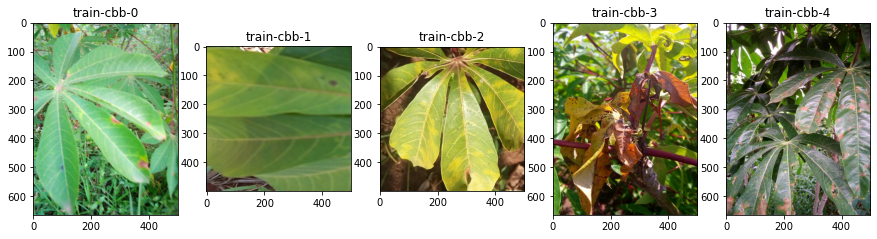

In [6]:
visualize('cbb') # Bacterial Blight Disease

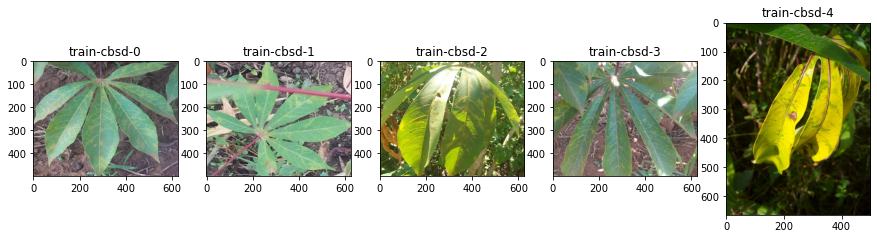

In [7]:
visualize('cbsd') # Brown Streak Disease

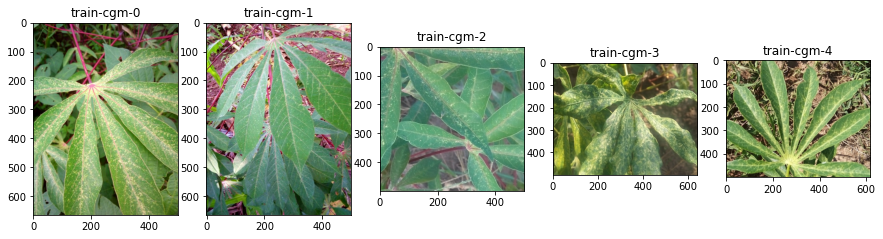

In [8]:
visualize('cgm') # Green Mite Disease

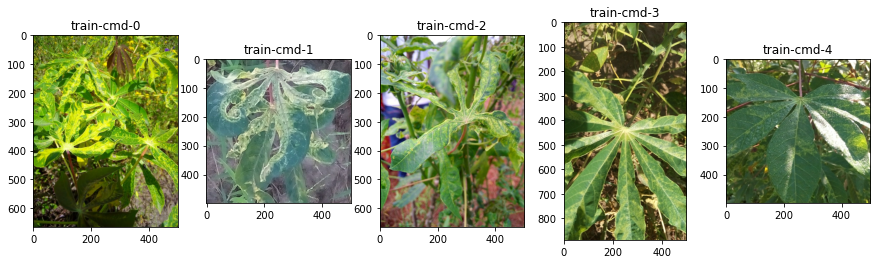

In [9]:
visualize('cmd') # Mosaic Disease

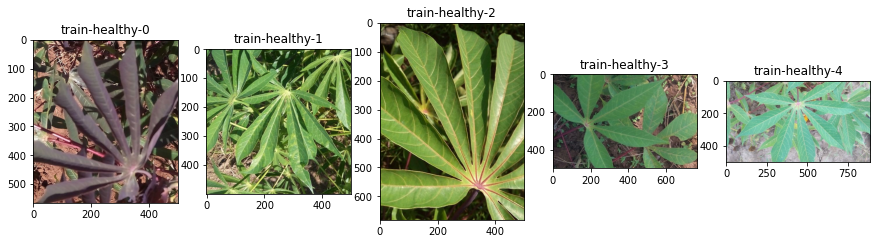

In [10]:
visualize('healthy')

This looks like a difficult task! How might you design a rule-based classifier for this problem?

 **Class Imbalance**

Also note that these five classes are not evenly balanced in the training set:

In [4]:
kaggleTrainDir = '/tmp/train'
cxnames = os.listdir(kaggleTrainDir)
numSamples = [len(os.listdir(os.path.join(kaggleTrainDir,c)))  for c in cxnames]
numClasses = len(cxnames)
for j in range(numClasses):
    print('class %s: %d/%d: (%.2f%%)' % (cxnames[j],numSamples[j],sum(numSamples),100*numSamples[j]/sum(numSamples)))


class cgm: 773/5656: (13.67%)
class cbb: 466/5656: (8.24%)
class cbsd: 1443/5656: (25.51%)
class healthy: 316/5656: (5.59%)
class cmd: 2658/5656: (46.99%)


cmd (Mosaic Disease) constitutes almost half the images. More than 2/3 are either cmd or csbd. 

Only 5% of our training images are healthy plants.

Recall that our usual metrics for deep learning classification problems are loss and accuracy.

Accuracy is a natural measure because it is easy to interpret and to understand what it tells us about a model's performance. (Although the bar for "good" accuracy is very different from one task to another! Here are [a few examples](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall) of why).

The discontinuities in accuracy, as measured against a fixed dataset, prevent algorithms based on gradient-descent optimization (e.g. deep learning) from using it as a cost function.

Instead we use crossentropy loss, which is continuous, and has some desirable properties. Specifically: we can solve a simple calculus problem to show that loss will be minimized when the model outputs class probabilities equal to the proportions in the dataset.

Another observation: the Kaggle dataset contains 5656 training images, but the others are all unlabeled. If we grab the dataset from Tensorflow Datasets instead, we can get 3774 more labeled images, conveniently pre-separated into validation and test sets:

In [5]:
cassava, info =  tfds.load('cassava', as_supervised=True, with_info=True)

In [5]:
# Look at metadata:
info

tfds.core.DatasetInfo(
    name='cassava',
    version=0.1.0,
    description='Cassava consists of leaf images for the cassava plant depicting healthy and
four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
Dataset consists of a total of 9430 labelled images.
The 9430 labelled images are split into a training set (5656), a test set(1885)
and a validation set (1889). The number of images per class are unbalanced with
the two disease classes CMD and CBSD having 72% of the images.',
    homepage='https://www.kaggle.com/c/cassava-disease/overview',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=9430,
    splits={
        'test': 1885,
        'train': 5656,
        'validation': 1889,
 

In [6]:
train_dataset,val_dataset,test_dataset = cassava['train'], cassava['validation'], cassava['test']
num_train_examples= info.splits['train'].num_examples
num_val_examples= info.splits['validation'].num_examples
num_test_examples= info.splits['test'].num_examples
print((num_train_examples,num_val_examples,num_test_examples))

(5656, 1889, 1885)


Okay, let's explore some models.

We'll consider only basic approaches here, more to develop a better understanding of the problem and not to maximize performance.

Note: the most performant models in this domain are built with transfer learning. Two transfer learning examples that were shared at our meetup:
add links here to George and David's notebooks

Let's start with looking at how some of the models presented in [Tensorflow in Practice, Course 2 (Convolutional Neural Networks)](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow) perform on this task.

First we will need to pre-process the image data to prepare it for our neural network. First convert the data from uint8 (0-255) to float (0.-1.) representation. Then we will also need to standardize the input image size. The cassava images are various sizes and shapes but the models will need to ingest uniform image batches. We'll go with 224x224

In [7]:
target_image_dim=224

def convert_and_resize(image,label):
    image = tf.image.convert_image_dtype(image,tf.float32) # cast and normalize the image to [0,1]
    image = tf.image.resize_with_pad(image, target_image_dim, target_image_dim)
    return (image,label)

Also let's train with mini-batches of size 64:

In [8]:
BATCH_SIZE=64
train_batches = (
    train_dataset
    .cache()
    .shuffle(num_train_examples//4)
    .map(convert_and_resize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
validation_batches = (
    val_dataset
    .map(convert_and_resize, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

We'll choose two models from in TFIP class: a fully-connected network with 2 hidden layers, and a small convolutional neural network.

Fully connected NN:

In [9]:
def make_model_FullyConnected():
    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(target_image_dim, target_image_dim, 3)),
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(numClasses, activation='softmax')
    ])
    model.compile(optimizer = 'adam',
                loss='sparse_categorical_crossentropy',#tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

We'll also try the small CNN, with four convolutional blocks, that was presented in Week 4 of the course for the Rock/Paper/Scissors classification task:

In [10]:
def make_model_smallCNN():
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image, with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(target_image_dim, target_image_dim, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(numClasses, activation='softmax')
    ])
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Let's see how these do on our data:

In [28]:
model_FC_0 = make_model_FullyConnected()
model_FC_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              154141696 
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 154,405,381
Trainable params: 154,405,381
Non-trainable params: 0
_________________________________________________________________


In [29]:
hist_FC_0 = model_FC_0.fit(train_batches, epochs=50, validation_data=validation_batches)
model_FC_0.save("cassava_FC_0.h5")

Epoch 1/50
89/89 [==============================] - 18s 201ms/step - loss: 21.0281 - accuracy: 0.4006 - val_loss: 4.2544 - val_accuracy: 0.5267
Epoch 2/50
89/89 [==============================] - 17s 192ms/step - loss: 2.7300 - accuracy: 0.4595 - val_loss: 2.0834 - val_accuracy: 0.3859
Epoch 3/50
89/89 [==============================] - 18s 197ms/step - loss: 1.9030 - accuracy: 0.5016 - val_loss: 1.7793 - val_accuracy: 0.4521
Epoch 4/50
89/89 [==============================] - 19s 211ms/step - loss: 1.4729 - accuracy: 0.5331 - val_loss: 2.2161 - val_accuracy: 0.5056
Epoch 5/50
89/89 [==============================] - 17s 192ms/step - loss: 1.1948 - accuracy: 0.5948 - val_loss: 1.2511 - val_accuracy: 0.5511
Epoch 6/50
89/89 [==============================] - 18s 199ms/step - loss: 1.1299 - accuracy: 0.6061 - val_loss: 2.0341 - val_accuracy: 0.3679
Epoch 7/50
89/89 [==============================] - 18s 207ms/step - loss: 1.0202 - accuracy: 0.6282 - val_loss: 1.3249 - val_accuracy: 0.492

In [34]:
del model_FC_0

In [38]:
model_CNN_0 = make_model_smallCNN()
model_CNN_0.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

In [39]:
hist_CNN_0 = model_CNN_0.fit(train_batches, epochs=50, validation_data=validation_batches)
model_CNN_0.save("cassava_CNN_0.h5")

Epoch 1/50
89/89 [==============================] - 20s 220ms/step - loss: 1.2774 - accuracy: 0.5143 - val_loss: 1.1731 - val_accuracy: 0.5638
Epoch 2/50
89/89 [==============================] - 17s 193ms/step - loss: 1.1369 - accuracy: 0.5842 - val_loss: 1.0947 - val_accuracy: 0.5956
Epoch 3/50
89/89 [==============================] - 18s 198ms/step - loss: 1.0559 - accuracy: 0.6096 - val_loss: 1.1285 - val_accuracy: 0.5786
Epoch 4/50
89/89 [==============================] - 18s 207ms/step - loss: 1.0012 - accuracy: 0.6351 - val_loss: 0.9954 - val_accuracy: 0.6358
Epoch 5/50
89/89 [==============================] - 18s 200ms/step - loss: 0.9505 - accuracy: 0.6457 - val_loss: 0.9745 - val_accuracy: 0.6464
Epoch 6/50
89/89 [==============================] - 18s 197ms/step - loss: 0.8915 - accuracy: 0.6685 - val_loss: 0.9546 - val_accuracy: 0.6660
Epoch 7/50
89/89 [==============================] - 18s 199ms/step - loss: 0.8212 - accuracy: 0.6952 - val_loss: 0.9574 - val_accuracy: 0.6517

In [41]:
del model_CNN_0

In [9]:
import matplotlib.pyplot as plt
def plotAccLoss(myHistory,startEpoch=0):
    acc = myHistory.history['accuracy'][startEpoch:]
    val_acc = myHistory.history['val_accuracy'][startEpoch:]
    loss = myHistory.history['loss'][startEpoch:]
    val_loss = myHistory.history['val_loss'][startEpoch:]

    epochs = range(startEpoch,startEpoch+len(acc))
    fig=plt.figure(figsize=(8,6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(epochs, acc, 'ro-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'bo-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    fig2=plt.figure(figsize=(8,6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(epochs, loss, 'ro-', label='Training loss')
    plt.plot(epochs, val_loss, 'bo-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

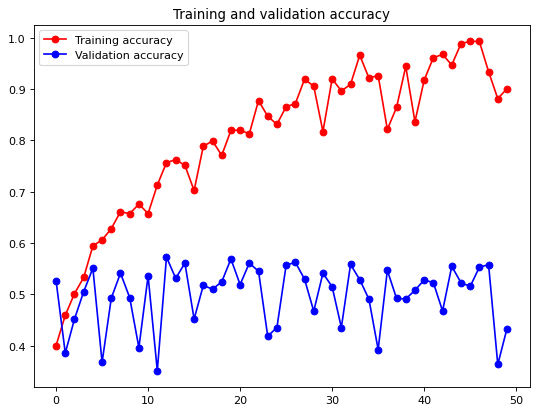

<Figure size 432x288 with 0 Axes>

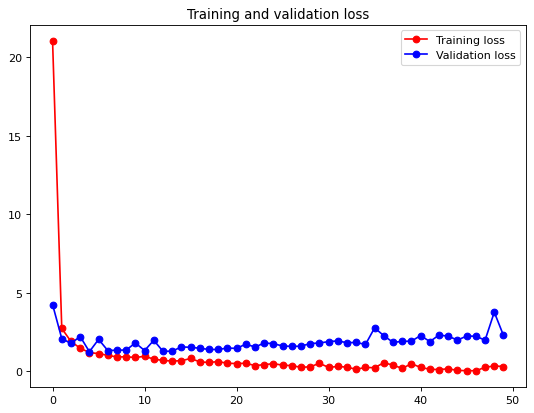

<Figure size 432x288 with 0 Axes>

In [33]:
plotAccLoss(hist_FC_0)

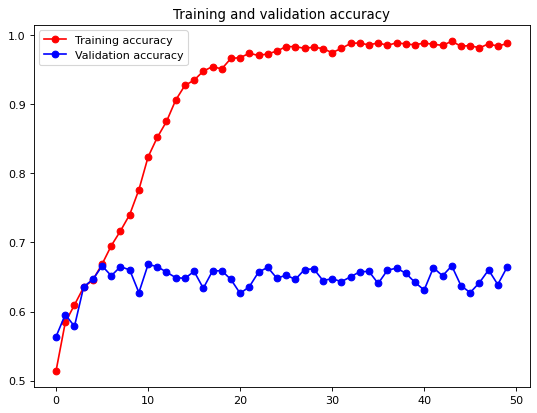

<Figure size 432x288 with 0 Axes>

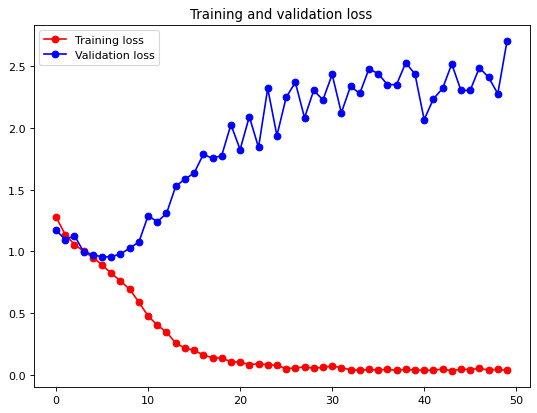

<Figure size 432x288 with 0 Axes>

In [42]:
plotAccLoss(hist_CNN_0)

In [10]:
def augment(image,label):
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize_with_pad(image, target_image_dim, target_image_dim)
    image = tf.image.random_crop(image,size=(target_image_dim//2,target_image_dim//2,3))
    image = tf.image.resize_with_pad(image, target_image_dim, target_image_dim)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image,0.0,3.0)
    image = tf.image.random_brightness(image,0.3)
    image = tf.image.random_contrast(image,0.5,2.0)
    return (image,label)

In [11]:
BATCH_SIZE=64
augmented_train_batches = (
    train_dataset
    .cache()
    .shuffle(num_train_examples//4)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 
validation_batches = (
    val_dataset
    .map(convert_and_resize, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [13]:
model_FC_1 = make_model_FullyConnected()
hist_FC_1 = model_FC_1.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)
model_FC_1.save("cassava_FC_1.h5")

Epoch 1/50
89/89 [==============================] - 35s 397ms/step - loss: 32.5729 - accuracy: 0.3326 - val_loss: 4.8579 - val_accuracy: 0.4738
Epoch 2/50
89/89 [==============================] - 23s 263ms/step - loss: 6.7405 - accuracy: 0.3289 - val_loss: 1.6055 - val_accuracy: 0.4621
Epoch 3/50
89/89 [==============================] - 23s 253ms/step - loss: 2.5568 - accuracy: 0.3506 - val_loss: 1.8586 - val_accuracy: 0.4203
Epoch 4/50
89/89 [==============================] - 23s 260ms/step - loss: 2.2011 - accuracy: 0.3547 - val_loss: 1.7442 - val_accuracy: 0.3145
Epoch 5/50
89/89 [==============================] - 23s 263ms/step - loss: 2.2003 - accuracy: 0.3579 - val_loss: 1.8610 - val_accuracy: 0.3642
Epoch 6/50
89/89 [==============================] - 23s 254ms/step - loss: 1.8269 - accuracy: 0.3748 - val_loss: 1.6456 - val_accuracy: 0.4696
Epoch 7/50
89/89 [==============================] - 25s 277ms/step - loss: 1.5178 - accuracy: 0.4243 - val_loss: 1.3088 - val_accuracy: 0.481

In [20]:
del model_FC_1

In [21]:
model_CNN_1 = make_model_smallCNN()
hist_CNN_1 = model_CNN_1.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)
model_CNN_1.save("cassava_CNN_1.h5")

Epoch 1/50
89/89 [==============================] - 27s 298ms/step - loss: 1.3616 - accuracy: 0.4524 - val_loss: 1.3157 - val_accuracy: 0.4696
Epoch 2/50
89/89 [==============================] - 25s 284ms/step - loss: 1.2957 - accuracy: 0.4851 - val_loss: 1.4154 - val_accuracy: 0.4696
Epoch 3/50
89/89 [==============================] - 26s 292ms/step - loss: 1.2679 - accuracy: 0.5034 - val_loss: 1.3192 - val_accuracy: 0.4717
Epoch 4/50
89/89 [==============================] - 25s 281ms/step - loss: 1.2478 - accuracy: 0.5179 - val_loss: 1.2348 - val_accuracy: 0.5257
Epoch 5/50
89/89 [==============================] - 26s 295ms/step - loss: 1.2161 - accuracy: 0.5332 - val_loss: 1.1787 - val_accuracy: 0.5723
Epoch 6/50
89/89 [==============================] - 25s 282ms/step - loss: 1.2147 - accuracy: 0.5309 - val_loss: 1.1555 - val_accuracy: 0.5738
Epoch 7/50
89/89 [==============================] - 25s 280ms/step - loss: 1.1937 - accuracy: 0.5483 - val_loss: 1.1781 - val_accuracy: 0.5474

In [22]:
del model_CNN_1

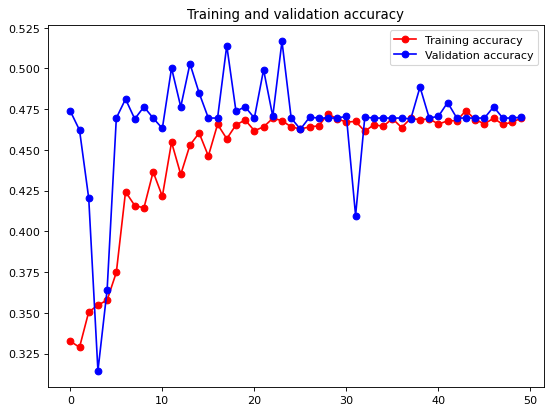

<Figure size 432x288 with 0 Axes>

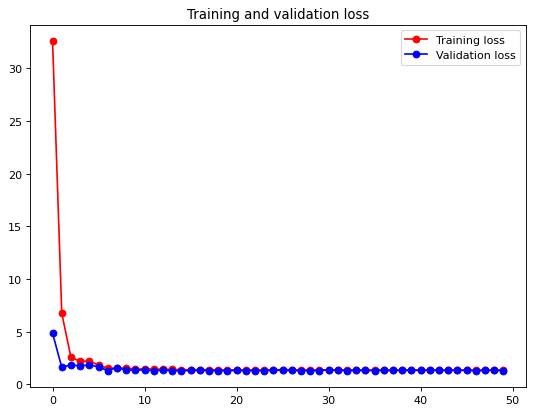

<Figure size 432x288 with 0 Axes>

In [16]:
plotAccLoss(hist_FC_1)

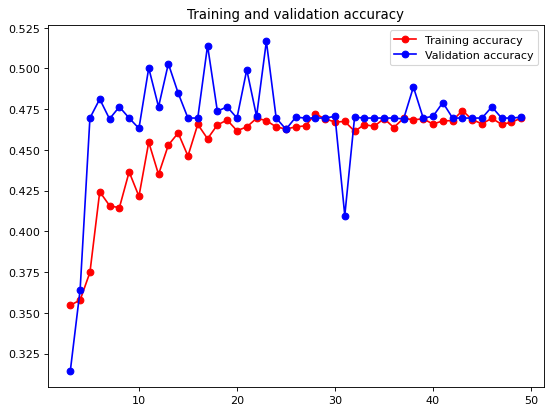

<Figure size 432x288 with 0 Axes>

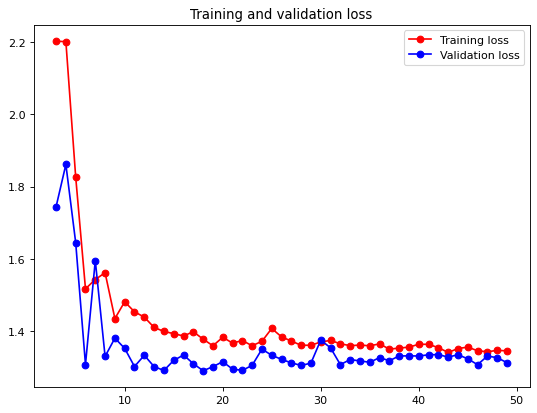

<Figure size 432x288 with 0 Axes>

In [19]:
plotAccLoss(hist_FC_1,startEpoch=3)

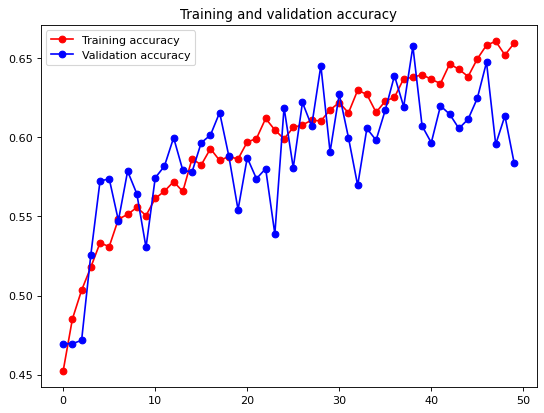

<Figure size 432x288 with 0 Axes>

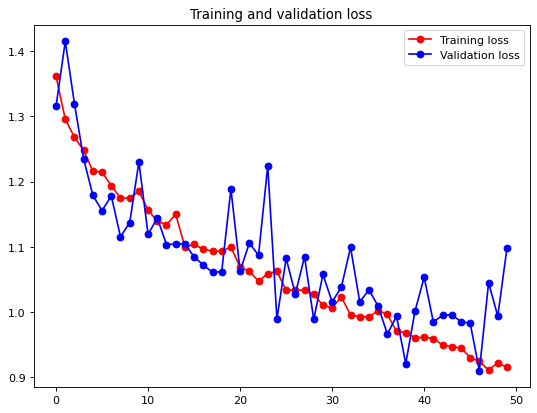

<Figure size 432x288 with 0 Axes>

In [23]:
plotAccLoss(hist_CNN_1)

Observations:

Overfitting is no longer an issue. The CNN shows possibly a divergence between train and val in the last few epochs, but before that it was tracking well.

Training set performance is much lower with augmentations, as should be expected. But validation (and eventually, test) performance are the true measure of generalization ability.

Validation performance is significantly improved, for both models, when looking at loss metric alone. Accuracy does not show the same bump from augmentation, at least through 50 epochs. The lower loss function is probably telling us that our original models were overconfident in their predictions; they could get away with that overconfidence on the training set but not the val set. With augmentation, the confidences (i.e. probability distribution) being predicted are more reasonable.

It is clear that longer training will not help the models without augmentation. Models using augmentation might benefit from additional epochs.

Fun diversion:

Can we train a model with an input data of all zeros? Purpose: get an idea of baseline performance, how well should the model do without any training images. 

With this model, we'll use SGD. 

In [12]:
# This is a hack, borrowing from our earlier augmentation code to convert and resize,
# but then just zero out the input images:

def killImage(image,label):
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize_with_pad(image, target_image_dim, target_image_dim)
    image =  tf.image.adjust_brightness(image,-2)   
    return (image,label)

In [13]:
BATCH_SIZE=56  # divides the trainset of 5656 evenly
killed_train_batches = (
    train_dataset
    .cache()
    .shuffle(num_train_examples//4)
    .map(killImage, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
validation_batches = (
    val_dataset
    .map(convert_and_resize, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [14]:
# another hack, forcing this calculation to fit earlier framework

def make_KilledModel():
    model = tf.keras.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(input_shape=(target_image_dim,target_image_dim, 3)),
        tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True)),
        tf.keras.layers.Dense(numClasses, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [15]:
model_K_0 = make_KilledModel()
model_K_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 3)                 0         
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Note that 5 of these parameters (the weights) are technically not accessible to the gradient descent process here, because the inputs are arrays of all zeros. So the biases are the only important parameters. We expect to learn biases that favor the most common classes.

In [16]:
hist_K_0 = model_K_0.fit(killed_train_batches, epochs=50, validation_data=validation_batches)
model_K_0.save("cassava_K_0.h5")

Epoch 1/50
101/101 [==============================] - 31s 307ms/step - loss: 2.1300 - accuracy: 0.0824 - val_loss: 1.5635 - val_accuracy: 0.4696
Epoch 2/50
101/101 [==============================] - 19s 183ms/step - loss: 2.0156 - accuracy: 0.0824 - val_loss: 1.5572 - val_accuracy: 0.4696
Epoch 3/50
101/101 [==============================] - 19s 191ms/step - loss: 1.9158 - accuracy: 0.0824 - val_loss: 1.5514 - val_accuracy: 0.4696
Epoch 4/50
101/101 [==============================] - 18s 179ms/step - loss: 1.8286 - accuracy: 0.0824 - val_loss: 1.5461 - val_accuracy: 0.4696
Epoch 5/50
101/101 [==============================] - 19s 183ms/step - loss: 1.7528 - accuracy: 0.0824 - val_loss: 1.5411 - val_accuracy: 0.4696
Epoch 6/50
101/101 [==============================] - 19s 187ms/step - loss: 1.6872 - accuracy: 0.0824 - val_loss: 1.5366 - val_accuracy: 0.4696
Epoch 7/50
101/101 [==============================] - 19s 190ms/step - loss: 1.6309 - accuracy: 0.0840 - val_loss: 1.5324 - val_ac

In [19]:
model_K_0.weights

[<tf.Variable 'dense/kernel:0' shape=(1, 5) dtype=float32, numpy=
 array([[-0.05387573, -0.37504268, -0.02617005, -0.43933097,  0.405814  ]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(5,) dtype=float32, numpy=
 array([-0.43006   ,  0.01689048, -0.03257139,  0.53628916, -0.09054808],
       dtype=float32)>]

This looks reasonable:

bias[3] is the highest, and we know that it corresponds to the most probable class (cmd)

In [22]:
model_K_0.weights[1].numpy()

array([-0.43006   ,  0.01689048, -0.03257139,  0.53628916, -0.09054808],
      dtype=float32)

In [30]:
def softmax(arr):
    expo = np.exp(arr)
    Z = sum(expo)
    return(expo/Z)

In [31]:
softmax(model_K_0.weights[1].numpy())

array([0.12369787, 0.1934062 , 0.18407269, 0.32511902, 0.17370424],
      dtype=float32)

Not quite the proportions of the original training set though. Perhaps this investigation will continue!